## Mixed models

#### Acknowledgements: 

Firstly, it's right to pay thanks to the blogs and sources I have used in writing this tutorial. A similar tutoral in R formed much of the framework by [Gabriela K Hajduk](https://twitter.com/AmidstScience), [Liam Bailey](https://twitter.com/ldbailey255) and the brilliant https://ourcodingclub.github.io/ - if you are an R developer check it out. Also big thanks to Junpeng Lao (https://github.com/junpenglao) for detailing the many different ways you can implement mixed-effect models in python (as there is always more than one), so look in the extension material in the end for links to one of his notebooks.

### Dataset

Today we will be using a dataset that looks at the bounce rates of users of a website with cooking recipes. A bounce rate is a measure of how quickly someone leaves a website, e.g. the number of seconds after which a user first accesses a webpage from the website and then leaves. Most websites want individuals to stay on their websites for a long time as they are more likely to read another article, buy one of their products, click on some of the sponsored links etc. As such, it can be useful to understand why some users leave the website quicker than others. 

To investigate the bounce rate of the website, we chose three locations in 8 counties in England, and got members of the public of all ages to undertake a survey/test questionaire. In the test we asked them to use our search engine to query for something they want to eat this evening. The search engine listed our website first, as well as other websites that would be returned. The users that clicked on our website were then timed and their bounce time recorded. We also recorded their age, and made a note of the county and location.

We have been asked by the website to work out if younger individuals are more likely to leave the website quicker.

### 1. Interacting with the data

In [28]:
# import modules needed
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import sklearn as sk
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in our data
data = pd.read_csv('data.csv')
data.head(30)

,bounce_time,age,county,location
0,165.548520,16,devon,a
1,167.559314,34,devon,a
2,165.882952,6,devon,a
3,167.685525,19,devon,a
4,169.959681,34,devon,a
5,168.688747,47,devon,a
6,169.619382,7,devon,a
7,164.416273,8,devon,a
8,167.510430,8,devon,a
9,179.606068,7,devon,a


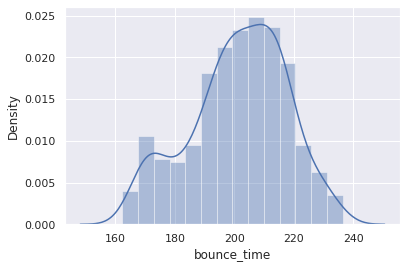

In [3]:
# plot the distribution of the bounce times - this creates the object that will be plotted when matplotlib.pyplot
sns.distplot(data.bounce_time)
plt.show()

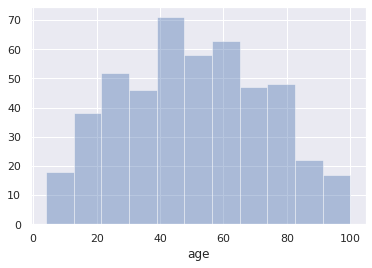

In [4]:
# plot the distribution of the ages
sns.distplot(data.age, kde=False)
plt.show()

Before we carry on it is often a good idea to **scale** our independent (explanatory) variables so that they are **standardised**. This is useful as it means that any estimated coefficient from our regression model later on are all on the same scale. So, for our dataset this would be the age, and let's create a new variable called **age_scaled**, which is the age scaled to have zero mean and unit variance:

In [5]:
# lets use the scale function from the preprocess package within sklearn
from sklearn import preprocessing
data["age_scaled"] = preprocessing.scale(data.age.values)

This scaling won't impact the statistical findings in our example but you may find in more complex models than the one in this tutorial this can be very helpful in speeding up your models fitting. It is also makes comparison between a continous variable like age, and a binary variable (0, 1) more fair. Thanks to a couple of the s2ds people from last night for asking about this!

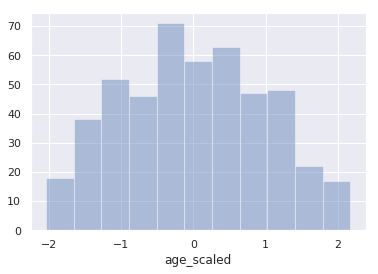

In [6]:
# plot the distribution
sns.distplot(data.age_scaled, kde=False)
plt.show()

---

### 2. Linear Regression

The first thing we might want to do to see if the bounce time is dependent on the age is to plot this data, and then fit a linear regression to the data:

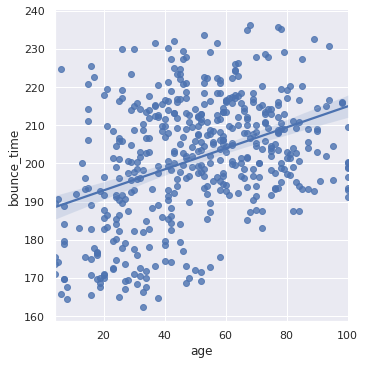

In [19]:
# let's use the lmplot function within seaborn
sns.lmplot(x = "age", y = "bounce_time", data = data)

It would seem, from this simple analysis that older people do spend longer time on the website. To go into this further let's look at what the coefficients estimated are within our linear model. We looked at similar things n a previous meetup on generalised linear models and at lasso and ridge regression (https://www.meetup.com/central_london_data_science/events/249149833/), so without repeating too much of the material from that meetup (github here - https://github.com/central-ldn-data-sci/regression2000), here is a quick overview again of what a linear regression model is

##### Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form

$$
y = b_0 + b_1x 
$$

where $b_1$ is commonly known as the *gradient*, and $b_0$ is commonly known as the *intercept*. So for our dataset, `y` would be the bounce time, `x` their age, `b_1` the rate of change of the bounce time with respect to `age` and `b_0` the intercept when `age` is 0.

$$
time = b_0 + b_1age
$$

We can use Scikit-Learn's ``LinearRegression`` estimator to fit this data and construct the best-fit line:

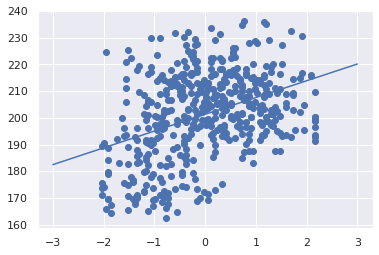

In [20]:
from sklearn.linear_model import LinearRegression

# construct our linear regression model
model = LinearRegression(fit_intercept=True)
x = data.age_scaled
y = data.bounce_time

# fit our model to the data
model.fit(x[:, np.newaxis], y)

# and let's plot what this relationship looks like 
xfit = np.linspace(-3, 3, 1000)
yfit = model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit);

We can have a look at these parameters within the model object, with the relevant parameters being ``coef_`` and ``intercept_``:

In [21]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     6.279602007970818
Model intercept: 201.31646151854164


In [22]:


# and let's store the rmse
y_predict = model.predict(x.values.reshape(-1,1))
RMSE = sqrt(((y-y_predict)**2).values.mean())



results = pd.DataFrame()
results["Method"] = ["Linear Regression"]
results["RMSE"] = RMSE
results

,Method,RMSE
0,Linear Regression,14.928334


In [25]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y, y_predict, squared=True)

rmse

222.85514442561683

So from this we would say quite confidently that as age increases so does the bounce time. (To test if this increase is significant see the take home challenge 1.)

However, to run a linear regression a number of assumptions about the data need to be met. One of these is that the residuals are **homoscedastic**, which means that the residuals are normally distributed in relation to the predicted value, i.e. are our predictions equally bad (or good) across our predicted values. We can look at this by plotting the residuals, using my new favourite package yellowbrick:


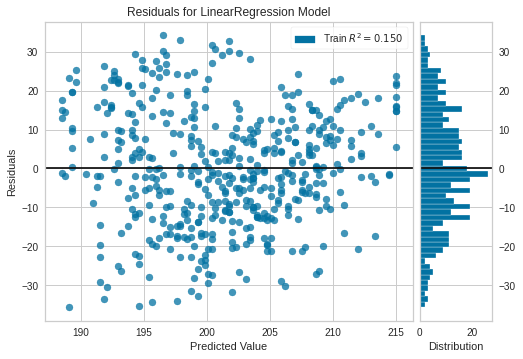

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [26]:
#!conda install -c districtdatalabs yellowbrick
import yellowbrick
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(model = model)

visualizer.fit(x[:, np.newaxis], y)  # Fit the training data to the model
visualizer.poof()                    # Draw/show/poof the data

Actually not toooooo bad - you could say that there are more positive residuals than negative residuals at the highest and lowest predicted value ranges, e.g. predicted value < 195, and >210 there are more positive residuals than negative. You can have a look at this also using seaborn's `residplot`:

ModuleNotFoundError: No module named 'statsmodels'

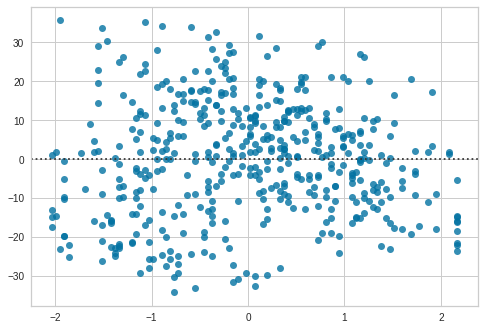

In [27]:
ax = sns.residplot(x = "age_scaled", y= "bounce_time", data = data, lowess = True)
ax.set(ylabel='Observed - Prediction')
plt.show()

Okay, so perhaps its not ideal...

Let's check some of the other assumptions. For a good list of the assumptions (with code in R), have a look here http://r-statistics.co/Assumptions-of-Linear-Regression.html. 

One of the other key assumption is that the observations of our data are independent of the other data. When we collected our data we were doing it in 8 different counties and in 3 locations within each county. So we could check this by comparing the bounce times for each county. To do this let's use one of the categorical plots in seaborn:

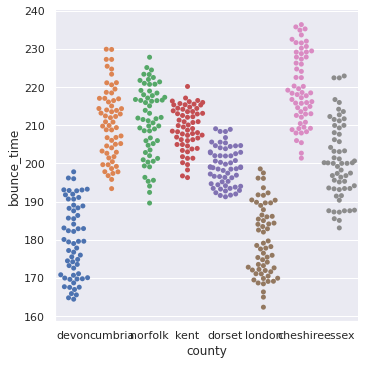

In [13]:
sns.catplot(x="county", y="bounce_time", data=data, kind = "swarm")

Ah... clearly there is substantial grouping - us Londoners seem to have short attention spans (maybe...). So we can definitely say that our data is not independent, and thus it is inappropriate to use a linear model for this data. 

What next? Well maybe we could do a separate regression for each county.

---

### 3a. Separate Linear Regression

Same as before, we are going to fit a linear regression to the data, but first separating it by county. Mathematically, this now looks like:

$$
time_c = b_{c0} + b_{c1}age
$$

where the subscript *c* here represents the county. As a result we will be estimating 8 different intercept and 8 different gradients, one for each county. Let's have a look at that using the facet grid options within `sns.lmplot`.

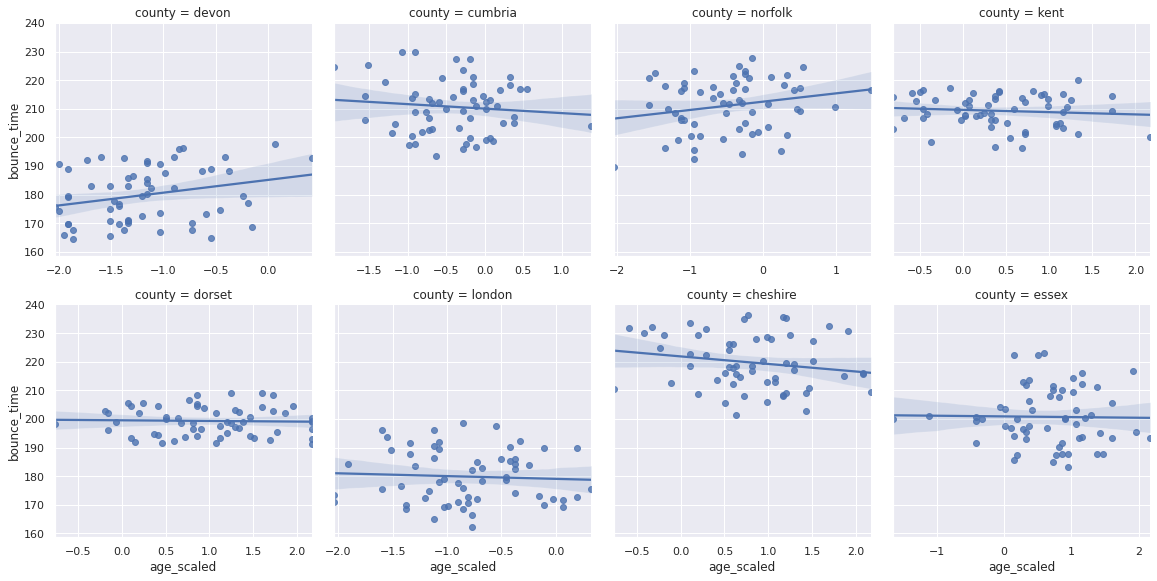

In [14]:
# let's use the lmplot function within seaborn
grid = sns.lmplot(x = "age_scaled", y = "bounce_time", col = "county", sharex=False, col_wrap = 4,
                  data = data, height=4)

So now we have 8 different analyses. This is fine, but we have started to reduce our sample size a lot already as a result, and we are now perhaps going too far in the other direction from before. Before we were saying that all counties were identical, whereas here we are saying that the impact of `age` on `bounce_time` share no similarities between counties, which is probably again not true.

In addition, what about our location variable, maybe our data is also not independent when looking at location. Let's have a look at this too, using a swarm plot:

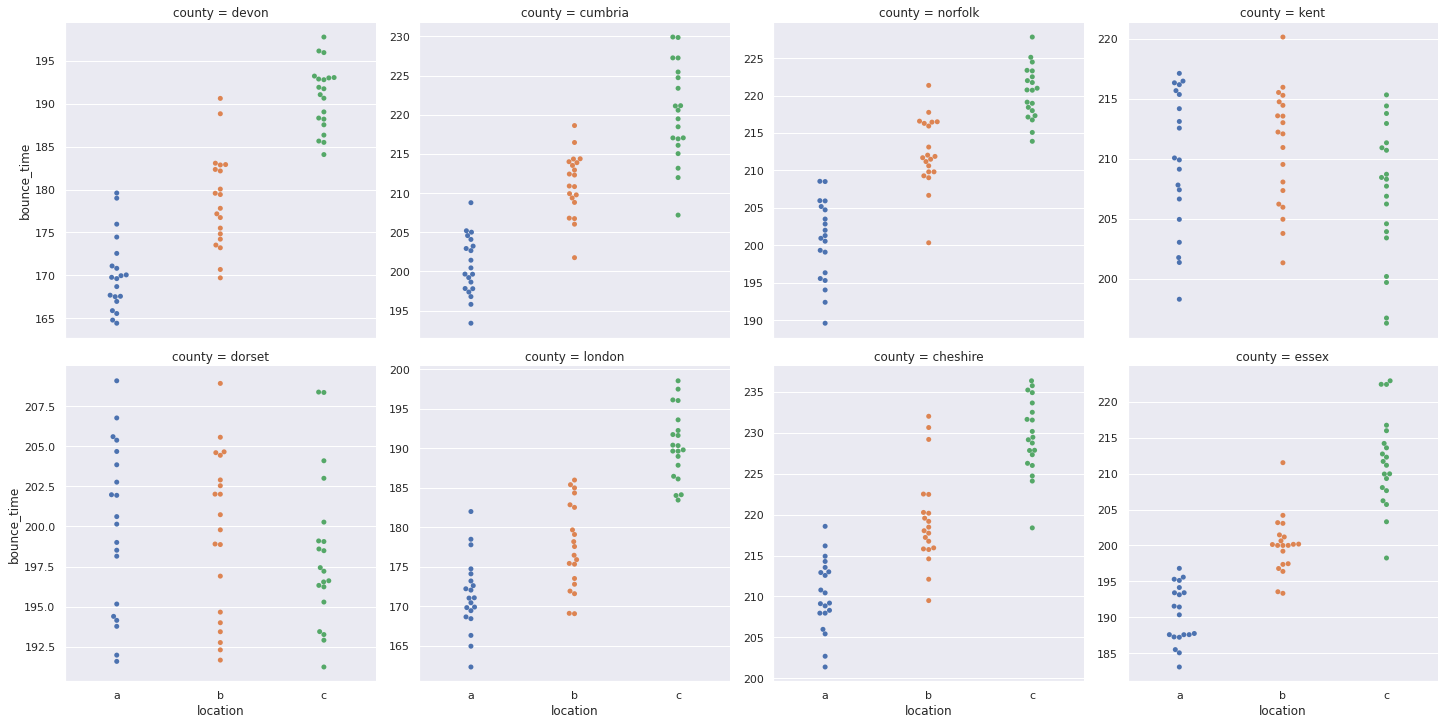

In [15]:
sns.catplot(x="location", y="bounce_time", col="county", col_wrap=4, sharey=False, data=data, kind = "swarm")

So we could carry on and then do an individual regression for each location within each county... hopefully you can see why we can't always just do an individual regression for each new group. If we did we would have to to estimate a slope and intercept parameter for each regression. That’s two parameters, three locations and eight counties, which means 48 parameter estimates (2 x 3 x 8 = 48). 

Also we would now be taking our nice dataset of 480 observations, that presumably took a long time to collect, and effectively reducing it to lots of sample sizes of 20. This really decreases our statistical power, and thus also increases our chances of a Type I Error (where you falsely reject the null hypothesis) by carrying out multiple comparisons.

So what could we do? Well we could modify the model to account for the different counties, and add it to our linear model.

___
### 3b. Modelling county as a fixed effect

One way to incorporate the impact of county is to bring the county in to our equation for the linear model by treating it as a fixed effect. This would look like: 

$$
time_{c_{i}} = b_{0} + b_{1}age + c_i
$$

i.e. each county has it's own additional term that wil change the intercept. To model this we will need to alter our dataframe to encode our counties as numeric variables. So we will use **one-hot encoding**, where we will make a new column for each county:

In [16]:
# make a new data frame with one hot encoded columns for the counties
counties = data.county.unique()
data_new = pd.concat([data,pd.get_dummies(data.county)],axis=1)
data_new.head()

,bounce_time,age,county,location,age_scaled,cheshire,cumbria,devon,dorset,essex,kent,london,norfolk
0,165.548520,16,devon,a,-1.512654,0,0,1,0,0,0,0,0
1,167.559314,34,devon,a,-0.722871,0,0,1,0,0,0,0,0
2,165.882952,6,devon,a,-1.951423,0,0,1,0,0,0,0,0
3,167.685525,19,devon,a,-1.381024,0,0,1,0,0,0,0,0
4,169.959681,34,devon,a,-0.722871,0,0,1,0,0,0,0,0


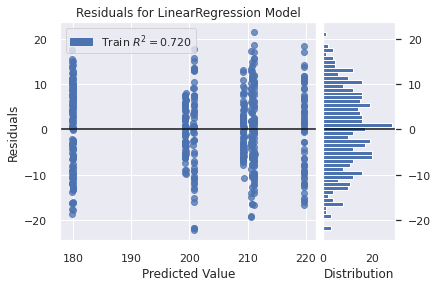

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [29]:
# construct our linear regression model
model = LinearRegression(fit_intercept=True)
x = data_new.loc[:,np.concatenate((["age_scaled"],counties))]
y = data.bounce_time

# fit our model to the data
model.fit(x, y)

# and let's plot what this relationship looks like 
visualizer = ResidualsPlot(model = model)
visualizer.fit(x, y)  # Fit the training data to the model
visualizer.poof()     

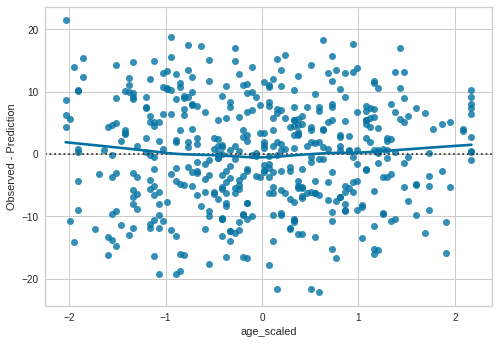

In [18]:
# and let's plot the predictions
performance = pd.DataFrame()
performance["residuals"] = model.predict(x) - data.bounce_time
performance["age_scaled"] = data.age_scaled
performance["predicted"] = model.predict(x)

ax = sns.residplot(x = "age_scaled", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

The residuals are much better than before, being more evenly distributed with respect to age, and if we look at the predictions with each county:

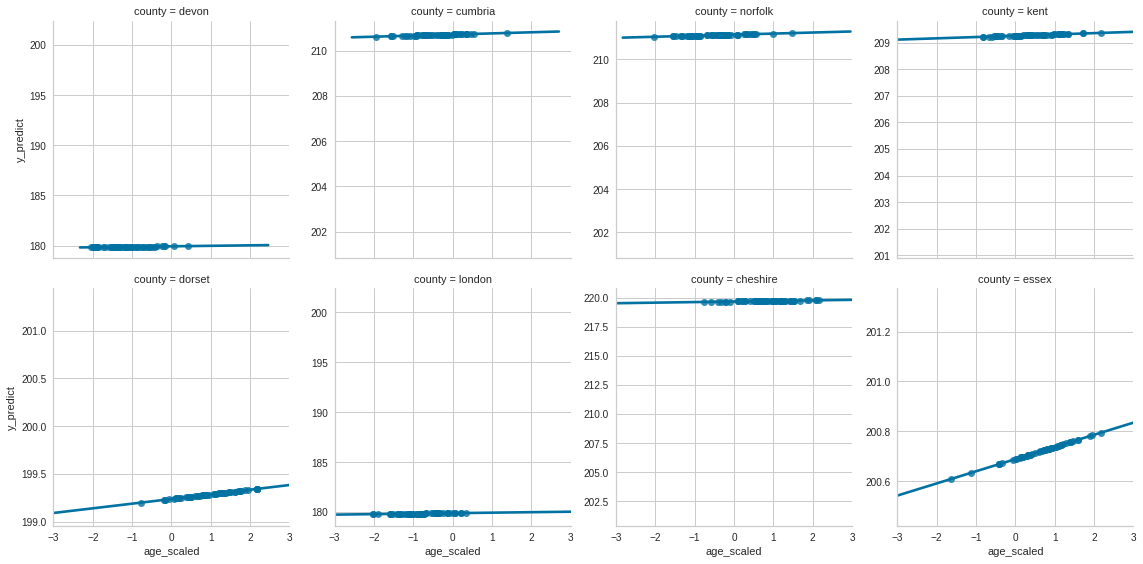

In [19]:
data_new["y_predict"] = model.predict(x)
grid = sns.lmplot(x = "age_scaled", y = "y_predict", col = "county", sharey=False, col_wrap = 4, data = data_new, height=4)
grid.set(xlim=(-3,3))

In [30]:
# and let's store the rmse
y_predict = model.predict(x)
RMSE = sqrt(((y-y_predict)**2).values.mean())
results.loc[1] = ["Fixed", RMSE]
results

,Method,RMSE
0,Linear Regression,14.928334
1,Fixed,8.563396


Now we can se that the coefficient for the gradient given to age is substnantially smaller, and is likely no longer significant. Let's just check that by making a table of the coefficients:

In [21]:
# coefficient for age and the counties
pd.DataFrame.from_records(list(zip(np.concatenate((["age_scaled"],counties)), model.coef_)))

,0,1
0,age_scaled,0.048782
1,devon,-21.381957
2,cumbria,9.391460
3,norfolk,9.824419
4,kent,7.938668
5,dorset,-2.079637
6,london,-21.437323
7,cheshire,18.372916
8,essex,-0.628546


But what model have we actually fitted here? Is it what we wanted to investigate initially? The  model is estimating the difference in bounce times between the counties now as well, and we aren't actually interested in that. If you were then this is correct to do so, but the website company just wanted to know whether age affects the bounce times. And by including county in we are obscuring this. So to look at the impact of age on bounce times we need to control for the variation between the different counties (as well as between the locations). So to do that, we have to treat our counties as **random effects**, and build a **mixed effect model**!

Hurray for getting here! 

![](https://memegenerator.net/img/instances/57364565/hurray-time-to-close-your-laptops.jpg)

.. just kidding ...

but you have now covered loads of material and can now have a go at using a mixed effect model. 

---


### 4. Mixed effects models

As we have discussed above, a mixed effects model is ideal here as it will allow us to both use all the data we have (higher sample size) and better acknowledge the correlations between data coming from the counties and locations. We will also estimate fewer parameters and avoid problems with multiple comparisons that we would encounter while using separate regressions.

So in this model we treat our `age`, which is what we are interested in, as a **fixed effect**, and `county` and `location` as a **random effect**.

But what does that mean? Well it's sort of a middle ground here between assuming our coefficient for the gradient and intercept are all the same (what we did in the first regression) and assuming they are all independent and different. If we look back at our equations, we now may assume that while $b_0$ and $b_1$ are different for each county, the coefficients all come from a common group distribution, such as a normal distribution:

$$
\begin{align*}
time_c = b_{c0} + b_{c1}.age  \\ \\
b_{c0} \sim N(\mu_{b_0}, \sigma^2_{b_0}) \\
b_{c1} \sim N(\mu_{b_1}, \sigma^2_{b_1})
\end{align*}
$$

So we now assume the intercepts $b_0$ and gradients $b_1$  come from a normal distribution centered around their respective group mean $\mu$ with a certain standard deviation $\sigma^2$, the values of which we also estimate.

#### Fixed vs random?

So what makes a variable a fixed or random effect. Hmmm, it's tricky and there are lots of answers out there. In brief, we view fixed effects as the variables that we are interested in. We wanted to know about age so we recorded data on that and wanted to see how it impacted the response variable. County was not we were interested in, but we recorded it as we were aware that our sampling methodology could lead to clustering in our data that could invalidate the linear model from before. If we hadn't recorded that someone who was given this dataset to analyse may have incorrectly said that  age was an important predictor of bounce rate.

Random effects are often our groups we are trying to control for, like county in our example. In particualr twe control for counties when we have not exhausted all the available groups - we only had 8 counties in England. If we wanted to make predicitons about the counties, then we would have tried to sample them better firstly, and also treat them as a fixed effect. 

Further reading for those who want a better answer!:

https://dynamicecology.wordpress.com/2015/11/04/is-it-a-fixed-or-random-effect/

And see the discussion in the paper linked in the take home challenge 3. 

#### Fitting our mixed effect lm

We will now fit our model using the `statsmodels` library. In this initial model we will look at how the bounce time relates to the scaled ages, while controlling for the impact of counties by allowing for a random intercept for each country, i.e. we are saying that each county has its own random intercept but that the slopes are still the same with respect to age.

In [31]:
#!conda install -c conda-forge statsmodels -y
import statsmodels.api as sm
import statsmodels.formula.api as smf

# construct our model, with our county now shown as a group
md = smf.mixedlm("bounce_time ~ age_scaled", data, groups=data["county"])
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: bounce_time
No. Observations: 480     Method:             REML       
No. Groups:       8       Scale:              74.7350    
Min. group size:  60      Log-Likelihood:     -1733.0397 
Max. group size:  60      Converged:          Yes        
Mean group size:  60.0                                   
---------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   201.316    5.175 38.902 0.000 191.174 211.459
age_scaled    0.136    0.612  0.221 0.825  -1.065   1.336
Group Var   212.999   13.382                             



In this summary of the model, we can clearly see that the `age_scaled` is having a more noticable impact than in the fixed model earlier (coefficient of 0.136 rather than 0.048), however, importantly it is still not significantly different to 0, with the 95% interval for this coefficient spanning -1.065 - 1.336.

And let's look at the predictions.

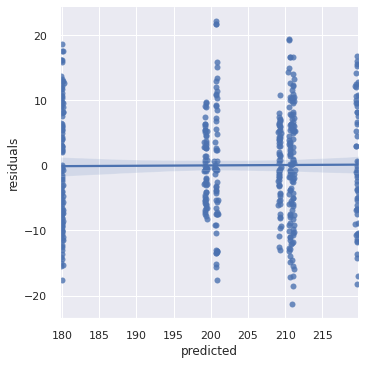

In [32]:
# and let's plot the predictions
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["age_scaled"] = data.age_scaled
performance["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance)

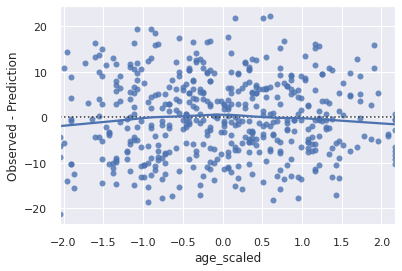

In [33]:
ax = sns.residplot(x = "age_scaled", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [34]:
# and let's store the rmse
y_predict = mdf.fittedvalues
RMSE = sqrt(((y-y_predict)**2).values.mean())
results.loc[2] = ["Mixed", RMSE]
results

,Method,RMSE
0,Linear Regression,14.928334
1,Fixed,8.563396
2,Mixed,8.563948


Huh, that's strange - it's very similar. In fact the residuals plot looks alomst identical to the previous one where we were treating the county as a fixed effect. Why? 

Well, have a think about what we have actually just implemented. All we have done is say in the last one that the county has a randome intercept, but the same slope. This is very similar to the fixed effect approach, where county was included as a term that would impact the intercept. All we have changed is sayng that the intercepts for each county are probably drawn from a similar distribution. To ensure that each county has its own random slope we need to include this in our random effects forumla, like so:

In [26]:
# construct our model, but this time we will have a random interecept AND a random slope with respect to age
md = smf.mixedlm("bounce_time ~ age_scaled", data, groups=data["county"], re_formula="~age_scaled")
mdf = md.fit()
print(mdf.summary())

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    bounce_time
No. Observations:      480        Method:                REML       
No. Groups:            8          Scale:                 72.8722    
Min. group size:       60         Likelihood:            -1733.3946 
Max. group size:       60         Converged:             No         
Mean group size:       60.0                                         
--------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              202.140    8.356 24.190 0.000 185.762 218.518
age_scaled               0.161    1.196  0.134 0.893  -2.184   2.505
Group Var              558.143                                      
Group x age_scaled Cov -51.614                                      
age_scaled Var           8.621                    

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2066: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


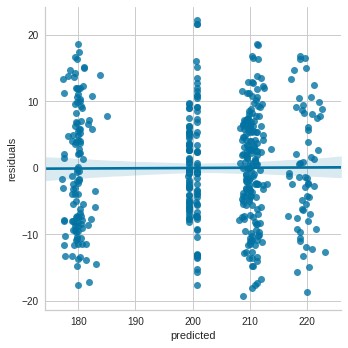

In [27]:
# and let's plot the predictions
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["age_scaled"] = data.age_scaled
performance["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance)

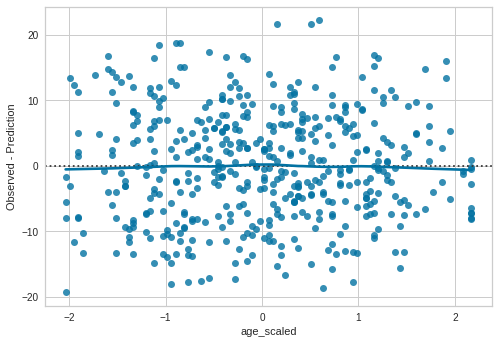

In [28]:
ax = sns.residplot(x = "age_scaled", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [29]:
# and let's store the rmse
y_predict = mdf.fittedvalues
RMSE = sqrt(((y-y_predict)**2).values.mean())
results.loc[3] = ["Mixed_Random_Slopes", RMSE]
results

,Method,RMSE
0,Linear Regression,14.928334
1,Fixed,8.563396
2,Mixed,8.563948
3,Mixed_Random_Slopes,8.475248


---


So our mixed model with the random slopes is now performing much better, with our residuals much better ditributed. Crucially though, we can see that age does not impact the bounce rate, with the confidence intervals for the gradient with respect to age spanning -2.184 - 2.505 after we have controlled for the random variation caused by the county properly, i.e. with a random slope and intercept. 

```
--------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------
Intercept                    202.140    8.356 24.190 0.000 185.762 218.518
age_scaled                     0.161    1.196  0.134 0.893  -2.184   2.505
Intercept RE                 558.143                              
Intercept RE x age_scaled RE -51.614                                 
age_scaled RE                  8.621                                      
==========================================================================
```

What we have seen in our data was that individuals in certain counties took longer on the website, and that they happened to also be old. However, to get to this distinction we had to first treat county as a random effect. But what about location? Eh? Forgot about that. See the take home material 4. for that one.

---

### 5. Wrap Up

Well done for getting this far! You know have an understanding of what a mixed effect model is, and how it alters the coefficients within regression models so you account for variation stemming from random variables. Reward yourselves with pizza!!!

![](https://i.imgflip.com/2gu0c8.jpg)

... or if you fancy there is some more material for those interested.

### Take home challenges

#### 1. Test the initial linear regression was significant

In section 2 we constructed a linear regression model on our data. It looked as if the coefficient for the gradient was significant, i.e. there was in fact a positive relationship between age and bounce time. However, to be sure we could use a statistical test, such as the **t.test** to test this. This can be often useful and can be used to produce **p.values** which gives us a measure of how confident we are about something. In this we will test whether the intercept and mean are significantly different from 0.

In [30]:
from scipy import stats

# construct our linear regression model
lm = LinearRegression(fit_intercept=True)
x = data.age
y = data.bounce_time

# fit our model to the data
lm.fit(x[:, np.newaxis], y)

# let's get our fitted parameters for the intercept and coefficient and what our predictions are
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(x.values.reshape(-1, 1))

# and let's simulate some new data for the model and then compare what the error is for these 
newx = pd.DataFrame({"Constant":np.ones(len(x))}).join(pd.DataFrame(x))
MSE = (sum((y-predictions)**2))/(len(newx)-len(newx.columns))

# and whats the variance, standard deviation, t values and p-values
var_b = MSE*(np.linalg.inv(np.dot(newx.T,newx)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b
p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newx)-1))) for i in ts_b]

# and let's group it together
names = ["intercept", "age"]
summary = pd.DataFrame()
summary["names"],summary["Coefficients"],summary["Standard Errors"] = [names,params,sd_b]
summary["t values"],summary["Probabilites"] = [ts_b,p_values]
print(summary)

       names  Coefficients      ...         t values  Probabilites
0  intercept    187.409130      ...       112.950956           0.0
1        age      0.275529      ...         9.196758           0.0

[2 rows x 5 columns]


Yup we can see that the probability that the intercept and age are not equal to 0 is is 0 (in fact it's <2e-16 but hey ho).

#### 2. Calculate the RMSE for the individual linear regressions

In section 3 we constructed mutliple linear regression models on our data. But how did they perform? Try and estimate the RMSE for each model.

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt

model = LinearRegression(fit_intercept=True)
rms = np.empty(counties.size)
mse = np.empty(counties.size)

for i in range(counties.size):
    county = counties[i]
    x = data.age[data.county == county].values.reshape(-1,1)
    y = data.bounce_time[data.county == county]
    fit = model.fit(x, y)
    predict = model.predict(x)
    mse[i] = mean_squared_error(y, predict)
    rms[i] = sqrt(mse[i])

sqrt(mse.sum())


23.914852863665146

#### 3. Add in locations for the mixed effect model

In section 4 we constructed our mixed effect model, treating county as a random effect. However, what about location? This will really improve our predictions.

**Hint: You will need to create a new variable that considers how the random effects are nested. For example there is nothing important about the locations a, b, and c that link location a in London with that in Essex. Therefore explicitly nest them**

In [32]:
# construct our model, with our county now shown as a group
data["location_county"] = data["location"] + "_" + data["county"]
data.head()

md = smf.mixedlm("bounce_time ~ age_scaled", data, groups=data["location_county"], re_formula="~age_scaled")
mdf = md.fit()
print(mdf.summary())

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    bounce_time
No. Observations:      480        Method:                REML       
No. Groups:            24         Scale:                 23.7951    
Min. group size:       20         Likelihood:            -1504.9092 
Max. group size:       20         Converged:             No         
Mean group size:       20.0                                         
--------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              201.493    3.448 58.439 0.000 194.735 208.250
age_scaled               0.151    0.393  0.385 0.700  -0.618   0.921
Group Var              282.798   21.303                             
Group x age_scaled Cov  -8.363    2.488                             
age_scaled Var           0.389    0.495           

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)


In [33]:
# and let's store the rmse
y_predict = mdf.fittedvalues
RMSE = sqrt(((y-y_predict)**2).mean())
results.loc[3] = ["Nested_Mixed", RMSE]
results

,Method,RMSE
0,Linear Regression,14.928334
1,Fixed,8.563396
2,Mixed,8.563948
3,Nested_Mixed,4.790665


#### 4. glm mixed effect for logistic

Wait, there's more data! Yup. In the other dataset, "data2.csv", you will know whether the individual chose a recipe from the website. So that's then a binary outcome. So wouldn't it be nice to fit a logistic regression, with the mixed effects? 

Yes it would! Fortunately, there is also a `statsmodels` for that that allows you to construct generalised linear mixed models, or GLMMs, so you can then specify what the relationship is between your data and the response (logistic). 

https://www.statsmodels.org/stable/generated/statsmodels.genmod.bayes_mixed_glm.BinomialBayesMixedGLM.html#statsmodels.genmod.bayes_mixed_glm.BinomialBayesMixedGLM

And if you want an example of how it's implemented, and some alternative ways of doing GLMMs, check out this great repo:

https://github.com/junpenglao/GLMM-in-Python

#### 5. Read on the strengths of a mutlievel (mixed-effects) modelling vs random forests.

Still here?? Really, well here is some reading by the godfather himself, Andrew Gelman, detailing what multilevel models can do:

http://www.stat.columbia.edu/~gelman/research/published/multi2.pdf

And for those who want to know how this stacks up against random forests:

https://epub.ub.uni-muenchen.de/39955/1/TR.pdf

#### 6. Compare performance to random forest

Seriously? Take a break...

... or how about comparing the performance of the mixed-effect models against a random forest for this dataset?

... nah just have pizza. 